In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder

In [13]:
import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
import numpyro.distributions as nd
from numpyro.infer import MCMC, NUTS

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import palettes

palettes.set_theme()

In [19]:
D = pd.read_csv("../data/elections.csv")
D.loc[:, "proportion"] = D.dem / (D.dem + D.rep)
D

,year,dem,rep,region,state,proportion
0,1976,44058,71555,Mountain West,AK,0.381082
1,1980,41842,86112,Mountain West,AK,0.327008
2,1984,62007,138377,Mountain West,AK,0.309441
3,1988,72584,119251,Mountain West,AK,0.378367
4,1992,78294,102000,Mountain West,AK,0.434257
...,...,...,...,...,...,...
545,2000,60481,147947,Mountain West,WY,0.290177
546,2004,70776,167629,Mountain West,WY,0.296873
547,2008,82868,164958,Mountain West,WY,0.334380
548,2012,69286,170962,Mountain West,WY,0.288394


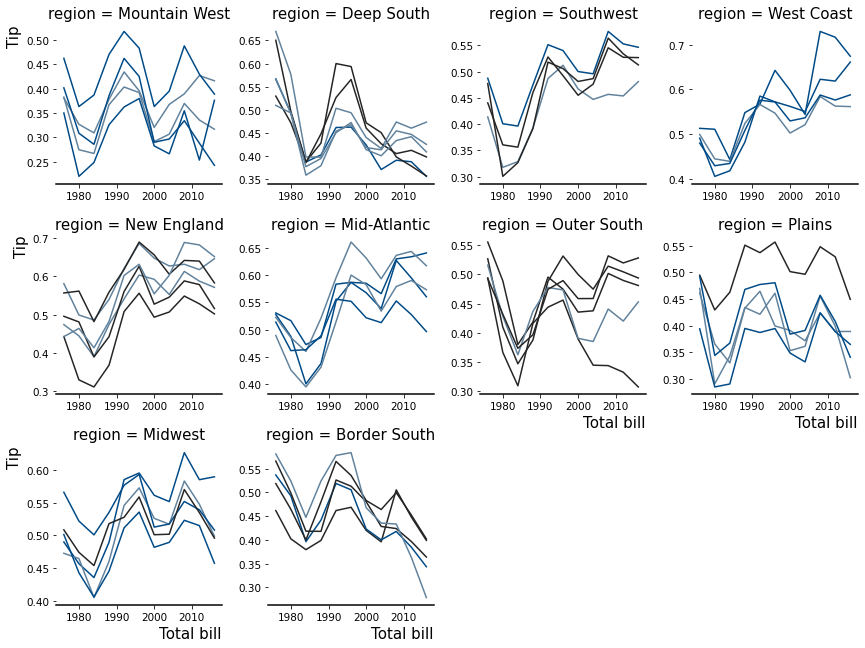

In [16]:
g = sns.FacetGrid(
    D, 
    col="region",
    hue="state",
    palette=palettes.discrete_sequential_colors(),     
    col_wrap=4,
    sharex=False, 
    sharey=False
)
g.map_dataframe(sns.lineplot, x="year", y="proportion")
g.set_axis_labels("Total bill", "Tip")
sns.despine(left=True)
plt.show()

In [6]:
Dmelt = D.melt(id_vars=["year", "region", "state"],
               value_vars=["dem", "rep"], 
               var_name='party', value_name='votes')

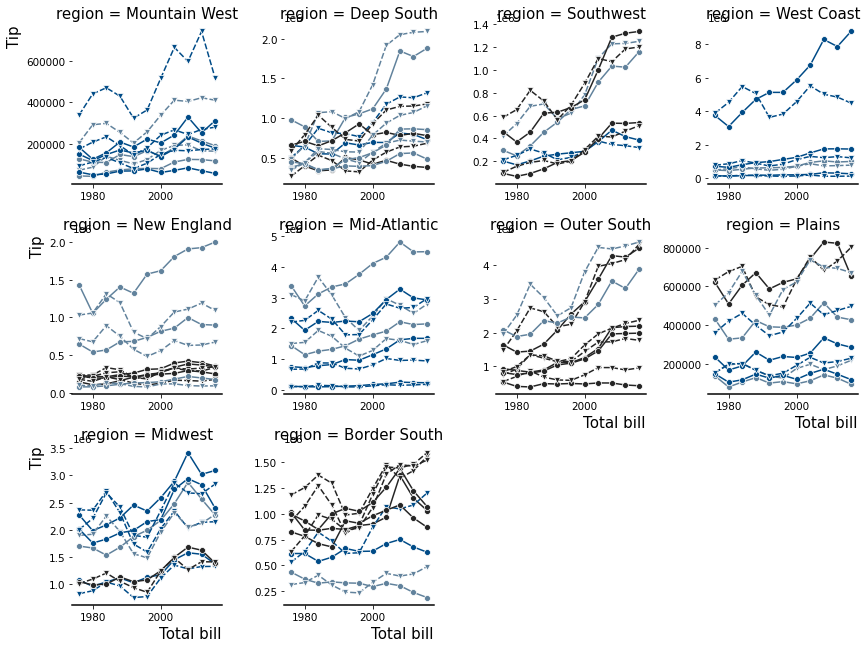

In [7]:
g = sns.FacetGrid(
    Dmelt, 
    col="region",
    hue="state",
    palette=palettes.discrete_sequential_colors(),     
    col_wrap=4,
    sharex=False, 
    sharey=False
)
g.map_dataframe(sns.lineplot, x="year", y="votes", style="party", markers=['o','v'])
g.set_axis_labels("Total bill", "Tip")
sns.despine(left=True)
plt.show()

In [9]:
def rbf(X1, X2, sigma=1.0, rho=1.0, jitter=1.0e-6):
    X1_e = np.expand_dims(X1, 1) / rho
    X2_e = np.expand_dims(X2, 0) / rho
    d = np.sum((X1_e - X2_e) ** 2, axis=2)    
    K = sigma * np.exp(-0.5 * d) + np.eye(d.shape[0]) * jitter
    return K

# A GP for a single time series

## Modelling counts using coregionalisation

In [10]:
D_ak = Dmelt.loc[Dmelt.state == "AK"]
years = pd.to_datetime(D_ak.year)
years = (years - years.min()) / pd.Timedelta(1)
D_ak.loc[:, ("year_numerical")] = years

In [11]:
D_ak

,year,region,state,party,votes,year_numerical
0,1976,Mountain West,AK,dem,44058,0.0
1,1980,Mountain West,AK,dem,41842,4.0
2,1984,Mountain West,AK,dem,62007,8.0
3,1988,Mountain West,AK,dem,72584,12.0
4,1992,Mountain West,AK,dem,78294,16.0
5,1996,Mountain West,AK,dem,80380,20.0
6,2000,Mountain West,AK,dem,79004,24.0
7,2004,Mountain West,AK,dem,111025,28.0
8,2008,Mountain West,AK,dem,123594,32.0
9,2012,Mountain West,AK,dem,122640,36.0


In [33]:
X = np.unique(D_ak.year_numerical).reshape(-1, 1)
y = np.array(D_ak["votes"].values)
y = (y  - np.mean(y)) / np.std(y)

In [36]:
def model(y, X, q=2):    
    rho = numpyro.sample("rho", nd.LogNormal(0.0, 2.0))        
    K = rbf(X, X, 1.0, rho)
    L = np.linalg.cholesky(K + np.eye(K.shape[0]) * 0.0000001)
    
    alpha = numpyro.sample("alpha", nd.Normal(np.zeros(q), 1.0))    
    omega = numpyro.sample("omega", nd.LKJCholesky(q, 2.0))
    
    f_tilde = numpyro.sample(
        "f_tilde", 
        nd.Normal(loc=np.zeros((X.shape[0], q)))
    )
    f = numpyro.deterministic(
        "f",
        L @ f_tilde @ (np.diag(alpha) @ omega).T
    )
    f = f.reshape(-1)
        
    sigma = numpyro.sample("sigma", nd.LogNormal(0.0, 1.0))    
    numpyro.sample("y", nd.Normal(f, sigma), obs=y)

In [37]:
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

kernel = NUTS(model)
mcmc = MCMC(
    kernel, 
    num_warmup=1000, 
    num_samples=1000, 
    num_chains=4,
    progress_bar=False
)
mcmc.run(rng_key, y, X)
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha[0]      0.26      0.95      0.65     -1.21      1.54      5.60      1.56
     alpha[1]      0.00      1.03      0.35     -1.46      1.38      6.21      1.63
 f_tilde[0,0]     -0.41      1.44     -0.96     -2.18      1.96      5.89      1.53
 f_tilde[0,1]     -0.00      0.95     -0.02     -1.54      1.50     14.14      1.19
 f_tilde[1,0]      0.01      0.84     -0.00     -1.47      1.28    559.36      1.00
 f_tilde[1,1]     -0.00      0.80     -0.00     -1.31      1.32    269.78      1.02
 f_tilde[2,0]      0.01      0.84     -0.03     -1.32      1.38    954.60      1.00
 f_tilde[2,1]      0.00      0.85     -0.00     -1.42      1.35   2354.60      1.00
 f_tilde[3,0]      0.03      0.86      0.03     -1.36      1.49   1150.98      1.00
 f_tilde[3,1]      0.01      0.89     -0.00     -1.55      1.38   1171.78      1.01
 f_tilde[4,0]      0.01      0.87      0.02     -1.45      1.37   1601.14  

# A hierarchical GP for a hierarchical time series

In [20]:
years = pd.to_datetime(D.year)
years = (years - years.min()) / pd.Timedelta(1)

In [21]:
D.loc[:, ("year_numerical")] = years
D = D.sort_values(["region", "state", "year_numerical"])
D

,year,dem,rep,region,state,proportion,year_numerical
154,1976,1014714,1183958,Border South,IN,0.461512,0.0
155,1980,844197,1255656,Border South,IN,0.402027,4.0
156,1984,841481,1377230,Border South,IN,0.379266,8.0
157,1988,860643,1297763,Border South,IN,0.398740,12.0
158,1992,848420,989375,Border South,IN,0.461651,16.0
...,...,...,...,...,...,...,...
512,2000,1247652,1108864,West Coast,WA,0.529448,24.0
513,2004,1510201,1304894,West Coast,WA,0.536465,28.0
514,2008,1750848,1229216,West Coast,WA,0.587520,32.0
515,2012,1755396,1290670,West Coast,WA,0.576283,36.0


In [22]:
D.loc[:, ("region_idxs")] = D['region'].apply(lambda x: list(D.region.unique()).index(x))
D.loc[:, ("state_idxs")] = D['state'].apply(lambda x: list(D.state.unique()).index(x))
D.loc[:, ("time_idxs")] = D['year_numerical'].apply(lambda x: list(D.year_numerical.unique()).index(x))

In [23]:
D

,year,dem,rep,region,state,proportion,year_numerical,region_idxs,state_idxs,time_idxs
154,1976,1014714,1183958,Border South,IN,0.461512,0.0,0,0,0
155,1980,844197,1255656,Border South,IN,0.402027,4.0,0,0,1
156,1984,841481,1377230,Border South,IN,0.379266,8.0,0,0,2
157,1988,860643,1297763,Border South,IN,0.398740,12.0,0,0,3
158,1992,848420,989375,Border South,IN,0.461651,16.0,0,0,4
...,...,...,...,...,...,...,...,...,...,...
512,2000,1247652,1108864,West Coast,WA,0.529448,24.0,9,49,6
513,2004,1510201,1304894,West Coast,WA,0.536465,28.0,9,49,7
514,2008,1750848,1229216,West Coast,WA,0.587520,32.0,9,49,8
515,2012,1755396,1290670,West Coast,WA,0.576283,36.0,9,49,9


In [256]:
X = np.array(D["year_numerical"].values).reshape(-1, 1)
Xu = np.unique(X).reshape(-1, 1)
y = np.array(D["proportion"].values)

In [365]:
X = np.array(D["year_numerical"].values).reshape(-1, 1)
Xu = np.unique(X).reshape(-1, 1)
y = np.array(D["proportion"].values)
time_idxs = np.array(D["time_idxs"].values)
n_times = len(np.unique(time_idxs))
state_idxs = np.array(D["state_idxs"].values)
n_states = len(np.unique(state_idxs))
region_idxs = np.array(D["region_idxs"].values)
n_regions = len(np.unique(region_idxs))

n_states_per_region = np.array(D.groupby(["region", "state"]).size().groupby("region").size())

In [429]:
def model(y, Xu, n_times, time_idxs, n_states, state_idxs, n_regions, region_idxs, n_states_per_region): 
    n = 5 # 2 * gps + 3 * thetas
    sigma_tot = numpyro.sample("sigma_tot", nd.Gamma(3.0, 3.0))
    sigma_prop = numpyro.sample("sigma_prop", nd.Dirichlet(np.repeat(2.0, n)))
    sigmas = n * sigma_prop * sigma_tot
    
    rho_region_gp = numpyro.sample("rho_region_gp", nd.LogNormal(0.0, 1.0))    
    K_region_gp = rbf(Xu, Xu, sigmas[0], rho_region_gp)
    L_region_gp = np.linalg.cholesky(K_region_gp)  
    with numpyro.plate("regions", size=n_regions):
        psi_reg = numpyro.sample("psi_reg", nd.Normal(0.0, sigmas[1])) 
        f_reg_tilde = numpyro.sample("f_reg_tilde", nd.Normal(loc=np.zeros((Xu.shape[0], 1))))
        f_reg = numpyro.deterministic("f_reg", L_region_gp @ f_reg_tilde)
    f_reg = np.repeat(f_reg, n_states_per_region, axis=1)
    f_reg = f_reg.T.reshape(-1)
    
    rho_state_gp = numpyro.sample("rho_state_gp", nd.LogNormal(0.0, 1.0))    
    K_state_gp = rbf(Xu, Xu, sigmas[2], rho_state_gp)        
    L_state_gp = np.linalg.cholesky(K_state_gp)
    with numpyro.plate("states", size=n_states):
        psi_stat = numpyro.sample("psi_stat", nd.Normal(0.0, sigmas[3]))
        f_stat_tilde = numpyro.sample("f_stat_tilde", nd.Normal(loc=np.zeros((Xu.shape[0], 1))))        
        f_stat = numpyro.deterministic("f_reg", L_state_gp @ f_stat_tilde)        
    f_stat = f_stat.reshape(-1)
            
    with numpyro.plate("times", size=n_times):
        psi_t = numpyro.sample("psi_t", nd.Normal(0.0, sigmas[4]))

    nu = numpyro.sample("nu", nd.Gamma(5.0, 0.01))
    mu = numpyro.sample("mu", nd.Normal(0.0, 0.5))    
    eta = nu * jax.scipy.special.expit(
        mu
        + f_reg
        + f_stat
        + psi_reg[region_idxs] 
        + psi_stat[state_idxs]
        + psi_t[time_idxs]
    )
    numpyro.sample("y", nd.Beta(eta, nu - eta), obs=y)

In [430]:
rng_key, rng_key_predict = random.split(random.PRNGKey(23))

kernel = NUTS(model)
mcmc = MCMC(
    kernel, 
    num_warmup=1000, 
    num_samples=1000, 
    num_chains=4,
    progress_bar=False
)
mcmc.run(rng_key, y, Xu, n_times, time_idxs, n_states, state_idxs, n_regions, region_idxs, n_states_per_region)
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
   f_reg_tilde[0,0]      0.99      0.60      0.97      0.01      1.99   1775.19      1.00
   f_reg_tilde[0,1]      1.80      0.63      1.77      0.80      2.83   1560.63      1.00
   f_reg_tilde[0,2]     -0.48      0.61     -0.46     -1.49      0.48   1660.04      1.00
   f_reg_tilde[0,3]     -0.27      0.58     -0.27     -1.26      0.63   2780.77      1.00
   f_reg_tilde[0,4]     -0.74      0.66     -0.75     -1.77      0.39    905.48      1.00
   f_reg_tilde[0,5]     -0.80      0.65     -0.78     -1.85      0.25   1053.91      1.00
   f_reg_tilde[0,6]      0.50      0.59      0.49     -0.39      1.51   1881.41      1.00
   f_reg_tilde[0,7]     -0.30      0.60     -0.31     -1.28      0.70   1398.17      1.00
   f_reg_tilde[0,8]     -1.11      0.57     -1.11     -2.00     -0.15   3130.56      1.00
   f_reg_tilde[0,9]     -1.05      0.63     -1.04     -2.04      0.01   1273.62      1.01
   f_reg_

In [10]:
## Another hierarchical GP for a hierarchical time series

In [435]:
def model(y, Xu, n_times, time_idxs, n_states, state_idxs, n_regions, region_idxs): 
    n = 3 # 3 * gps
    sigma_tot = numpyro.sample("sigma_tot", nd.Gamma(3.0, 3.0))
    sigma_prop = numpyro.sample("sigma_prop", nd.Dirichlet(np.repeat(2.0, n)))
    sigmas = n * sigma_prop * sigma_tot
    
    rho_region_gp = numpyro.sample("rho_region_gp", nd.LogNormal(0.0, 1.0))    
    K_region_gp = rbf(Xu, Xu, sigmas[0], rho_region_gp)
    L_region_gp = np.linalg.cholesky(K_region_gp)
    with numpyro.plate("regions", size=n_regions):        
        f_reg_tilde = numpyro.sample("f_reg_tilde", nd.Normal(loc=np.zeros((Xu.shape[0], 1))))
        f_reg = numpyro.deterministic("f_reg", L_region_gp @ f_reg_tilde)
    f_reg = np.repeat(f_reg, n_states_per_region, axis=1)
    f_reg = f_reg.T.reshape(-1)
        
    rho_state_gp = numpyro.sample("rho_state_gp", nd.LogNormal(0.0, 1.0))    
    K_state_gp = rbf(Xu, Xu, sigmas[1], rho_state_gp)        
    L_state_gp = np.linalg.cholesky(K_state_gp)
    with numpyro.plate("states", size=n_states):       
        f_stat_tilde = numpyro.sample("f_stat_tilde", nd.Normal(loc=np.zeros((Xu.shape[0], 1))))        
        f_stat = numpyro.deterministic("f_reg", L_state_gp @ f_stat_tilde)    
    f_stat = f_stat.reshape(-1)    
    
    with numpyro.plate("states", size=n_states):
        rho = numpyro.sample("rho", nd.LogNormal(0.0, 1.0))
        K = rbf(Xu, Xu, sigmas[2], rho)
        L = np.linalg.cholesky(K)
        f_tilde = numpyro.sample("f_tilde", nd.Normal(loc=np.zeros((Xu.shape[0], 1))))             
        f = numpyro.deterministic("f", L @ f_tilde)            
    f = f.reshape(-1) 
        
    nu = numpyro.sample("nu", nd.Gamma(5.0, 0.01))
    mu = numpyro.sample("mu", nd.Normal(0.0, 0.5))
    eta = nu * jax.scipy.special.expit(
        mu
        + f_reg
        + f_stat
        + f
    )
    numpyro.sample("y", nd.Beta(eta, nu - eta), obs=y)

In [436]:
rng_key, rng_key_predict = random.split(random.PRNGKey(23))

kernel = NUTS(model)
mcmc = MCMC(
    kernel, 
    num_warmup=1000, 
    num_samples=1000, 
    num_chains=4,
    progress_bar=False
)
mcmc.run(rng_key, y, Xu, n_times, time_idxs, n_states, state_idxs, n_regions, region_idxs)
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
   f_reg_tilde[0,0]      0.62      0.30      0.61      0.13      1.11   2352.09      1.00
   f_reg_tilde[0,1]      1.25      0.30      1.24      0.74      1.73   1825.47      1.00
   f_reg_tilde[0,2]      0.42      0.29      0.42     -0.04      0.91   2145.81      1.00
   f_reg_tilde[0,3]      0.32      0.29      0.33     -0.14      0.83   1640.11      1.00
   f_reg_tilde[0,4]     -1.15      0.32     -1.14     -1.68     -0.63   1661.66      1.00
   f_reg_tilde[0,5]      0.25      0.28      0.25     -0.24      0.68   2174.47      1.00
   f_reg_tilde[0,6]      0.38      0.29      0.38     -0.07      0.88   2209.94      1.00
   f_reg_tilde[0,7]     -0.39      0.30     -0.39     -0.85      0.11   2054.82      1.00
   f_reg_tilde[0,8]     -0.46      0.32     -0.46     -0.98      0.05   1949.06      1.00
   f_reg_tilde[0,9]      0.13      0.31      0.14     -0.37      0.63   2184.31      1.00
   f_reg_

In [ ]:
## Coregionalisation

In [29]:
D = Dmelt.copy()

In [146]:
D = D.sort_values(["party", "region", "state", "year"])

In [147]:
years = pd.to_datetime(D.year)
years = (years - years.min()) / pd.Timedelta(1)
D.loc[:, ("year_numerical")] = years

In [148]:
D.loc[:, ("region_idxs")] = D['region'].apply(
    lambda x: list(D.region.unique()).index(x)
)
D.loc[:, ("state_idxs")] = D['state'].apply(
    lambda x: list(D.state.unique()).index(x)
)
D.loc[:, ("time_idxs")] = D['year_numerical'].apply(
    lambda x: list(D.year_numerical.unique()).index(x)
)

In [163]:
X = np.array(D["year_numerical"].values).reshape(-1, 1)
Xu = np.unique(X).reshape(-1, 1)
y = np.array(D["votes"].values)
y = (y - np.mean(y)) / np.std(y)

In [164]:
time_idxs = np.array(D["time_idxs"].values)
n_times = len(np.unique(time_idxs))
state_idxs = np.array(D["state_idxs"].values)
n_states = len(np.unique(state_idxs))
region_idxs = np.array(D["region_idxs"].values)
n_regions = len(np.unique(region_idxs))

n_states_per_region = np.array(D.groupby(["region", "state"]).size().groupby("region").size())

In [165]:
def model(y, Xu, n_times, time_idxs, n_states, state_idxs, n_regions, region_idxs, q=2, delta=0.0000001): 
    n = 2 # 3a * gpsm but the last one is co-regional
    sigma_tot = numpyro.sample("sigma_tot", nd.Gamma(3.0, 3.0))
    sigma_prop = numpyro.sample("sigma_prop", nd.Dirichlet(np.repeat(2.0, n)))
    sigmas = n * sigma_prop * sigma_tot
    
    rho_region_gp = numpyro.sample("rho_region_gp", nd.LogNormal(0.0, 1.0))    
    K_region_gp = rbf(Xu, Xu, sigmas[0], rho_region_gp)
    L_region_gp = np.linalg.cholesky(K_region_gp + np.eye(K_region_gp.shape[0]) * delta)
    with numpyro.plate("regions", size=n_regions):        
        f_reg_tilde = numpyro.sample("f_reg_tilde", nd.Normal(loc=np.zeros((Xu.shape[0], 1))))
        f_reg = numpyro.deterministic("f_reg", L_region_gp @ f_reg_tilde)
    f_reg = np.repeat(f_reg, n_states_per_region, axis=1)
    f_reg = f_reg.T.reshape(-1)
        
    rho_state_gp = numpyro.sample("rho_state_gp", nd.LogNormal(0.0, 1.0))    
    K_state_gp = rbf(Xu, Xu, sigmas[1], rho_state_gp)        
    L_state_gp = np.linalg.cholesky(K_state_gp + np.eye(K_state_gp.shape[0]) * delta)
    with numpyro.plate("states", size=n_states):       
        f_stat_tilde = numpyro.sample("f_stat_tilde", nd.Normal(loc=np.zeros((Xu.shape[0], 1))))        
        f_stat = numpyro.deterministic("f_reg", L_state_gp @ f_stat_tilde)    
    f_stat = f_stat.reshape(-1)    
            
    rhos = numpyro.sample("rho", nd.LogNormal(0.0, 1.0), sample_shape=(n_states,))
    Ks = jax.vmap(lambda rho: rbf(Xu, Xu, 1.0, rho))(rhos)
    Ls = jax.vmap(lambda K: np.linalg.cholesky(K + np.eye(K.shape[0]) * delta))(Ks)    
    alphas = numpyro.sample("alpha", nd.Normal(np.zeros(q), 1.0), sample_shape=(n_states,))        
    omegas = numpyro.sample("omega", nd.LKJCholesky(q, 2.0), sample_shape=(n_states,))        
    f_tildes = numpyro.sample(
        "f_tilde", nd.Normal(loc=np.zeros((Xu.shape[0], 2))), sample_shape=(n_states,)
    )    
    fs = numpyro.deterministic(
        "f",
        jax.vmap(lambda L, f_tilde, alpha, omega: L @ f_tilde @ (np.diag(alpha) @ omega).T)
        (Ls, f_tildes, alphas, omegas)
    )    
    fs = fs.reshape(-1) 

    mu = numpyro.deterministic("mu", np.tile(f_reg + f_stat, 2) + fs)
    sigma = numpyro.sample("sigma", nd.LogNormal(0.0, 1.0))    
    numpyro.sample("y", nd.Normal(mu[:1000], sigma), obs=y[:1000])

In [ ]:
rng_key, rng_key_predict = random.split(random.PRNGKey(23))

kernel = NUTS(model)
mcmc = MCMC(
    kernel, 
    num_warmup=1000, 
    num_samples=1000, 
    num_chains=4,
    progress_bar=False
)
mcmc.run(rng_key, y, Xu, n_times, time_idxs, n_states, state_idxs, n_regions, region_idxs)
mcmc.print_summary()